In [1]:
!pip install wandb

     |████████████████████████████████| 1.7 MB 5.0 MB/s 
     |████████████████████████████████| 144 kB 68.6 MB/s 
     |████████████████████████████████| 181 kB 49.7 MB/s 
     |████████████████████████████████| 63 kB 1.3 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=53d4ff7740607a99fcc471d0f4614e2cf03e26748a8ebe46a9d1b3bfada697a9
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


In [2]:
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# Učitavanje datoteka

In [3]:
import pandas as pd

In [4]:
download_url = "https://drive.google.com/uc?id=1qXq6k2rNR_dgG9XA4uMjAeuzUYkGx7HZ"

In [5]:
train = pd.read_csv(download_url)
train.job_functions = train.job_functions.apply(eval)
train.industries = train.industries.apply(eval)

train.head()

,job_title,seniority_level,employment_type,industries,job_functions
0,Manual Tester,Entry level,Full-time,[Information Technology and Services],"[Engineering, Information Technology]"
1,Field Marketing Representative,Entry level,Full-time,"[Food & Beverages, Wholesale, Retail]","[Marketing, Sales]"
2,Consumer Relations Representative,Associate,Full-time,"[Marketing and Advertising, Food & Beverages, ...",[Other]
3,Software Engineer In Test,Mid-Senior level,Full-time,"[Information Technology and Services, Computer...","[Information Technology, Quality Assurance]"
4,Electrician,Entry level,Full-time,"[Electrical/Electronic Manufacturing, Construc...","[Management, Manufacturing]"


https://github.com/susanli2016/NLP-with-Python/blob/master/Multi-Class%20Text%20Classification%20LSTM%20Consumer%20complaints.ipynb

In [6]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import re

from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, GRU
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [20]:
import wandb
from wandb.keras import WandbCallback

# 1. Start a new run
wandb.init(project='lipik', entity='ivanzidov')

# 2. Save model inputs and hyperparameters
config = wandb.config
config.learning_rate = 0.01
config.lower_case = False
config.optimizer = "adam"
config.batch_size = 2048
config.dropout = 0.5
config.r_dropout = 0.5
config.lstm = 256
config.MAX_NB_WORDS = 20000
config.MAX_SEQUENCE_LENGTH = 16
config.EMBEDDING_DIM = 512
config.rnn_dim = 256
config.rnn_type = "gru"


In [21]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):

    if config.lower_case:
        text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    #text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    #text = text.replace('x', '')
    #text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text

train.job_title = train.job_title.apply(clean_text)

In [22]:
train.job_title

0                              Manual Tester
1             Field Marketing Representative
2          Consumer Relations Representative
3                  Software Engineer In Test
4                                Electrician
                        ...                 
99995                    Roof Loader Striker
99996       Quality Assurance Representative
99997         Paratransit shuttle Bus Driver
99998    Apprenticeship trained Patternmaker
99999                      Bridge Inspectors
Name: job_title, Length: 100000, dtype: object

In [23]:
#train.job_title.apply(lambda x: x.split(" "))

In [24]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = config.MAX_NB_WORDS
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = config.MAX_SEQUENCE_LENGTH
# This is fixed.
EMBEDDING_DIM = config.EMBEDDING_DIM


tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='', lower=config.lower_case)
tokenizer.fit_on_texts(train.job_title.values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 30405 unique tokens.


In [25]:
broj_ponavljanja_rijeci = list(tokenizer.word_counts.values())
sum(pd.Series(broj_ponavljanja_rijeci).sort_values(ascending=False)[:20000])/sum(broj_ponavljanja_rijeci)

0.9716223661028414

In [26]:
X = tokenizer.texts_to_sequences(train.job_title.values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (100000, 16)


In [38]:
Y_sen = pd.get_dummies(train.seniority_level).values
Y_emp = pd.get_dummies(train.employment_type).values

print('Shape of label tensor:', Y_sen.shape)
print('Shape of label tensor:', Y_emp.shape)

Shape of label tensor: (100000, 7)
Shape of label tensor: (100000, 7)


In [39]:
X_train, X_test, Y_sen_train, Y_sen_test, Y_emp_train, Y_emp_test = train_test_split(X,Y_sen,Y_emp, test_size = 0.20, random_state = 42)
print(X_train.shape,Y_sen_train.shape)
print(X_test.shape,Y_sen_test.shape)
print(X_train.shape,Y_emp_train.shape)
print(X_test.shape,Y_emp_test.shape)

(80000, 16) (80000, 7)
(20000, 16) (20000, 7)
(80000, 16) (80000, 7)
(20000, 16) (20000, 7)


In [40]:
X_train, X_val, Y_sen_train, Y_sen_val, Y_emp_train, Y_emp_val = train_test_split(X_train,Y_sen_train,Y_emp_train, test_size = 0.20, random_state = 30)
print(X_train.shape,Y_sen_train.shape)
print(X_test.shape,Y_sen_val.shape)
print(X_train.shape,Y_emp_train.shape)
print(X_test.shape,Y_emp_val.shape)

(64000, 16) (64000, 7)
(20000, 16) (16000, 7)
(64000, 16) (64000, 7)
(20000, 16) (16000, 7)


In [42]:
from tensorflow.keras.layers import *
from tensorflow.keras import Model,Input

In [61]:
input = Input(shape = MAX_SEQUENCE_LENGTH,name="job_title")

x = Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH) (input)
x = LSTM(64, dropout=config.dropout,return_sequences=True) (x)
x = LSTM(64, dropout=config.dropout,return_sequences=True) (x)
x = LSTM(64, dropout=config.dropout) (x)

z = Dense(64, activation='relu')(x)
out = Dense(7, activation='softmax',name="emp")(z)

out2 = Dense(64, activation='relu')(x)
out2 = Dense(32, activation='relu')(out2)
out2 = Dense(7, activation='softmax',name="sen")(out2)
#model.compile(loss='categorical_crossentropy', optimizer="nadam", metrics=['accuracy'])
model = Model(inputs = input,
     outputs = [out,out2])
model.summary()
print(model.summary())

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 job_title (InputLayer)         [(None, 16)]         0           []                               
                                                                                                  
 embedding_8 (Embedding)        (None, 16, 512)      10240000    ['job_title[0][0]']              
                                                                                                  
 lstm_12 (LSTM)                 (None, 16, 64)       147712      ['embedding_8[0][0]']            
                                                                                                  
 lstm_13 (LSTM)                 (None, 16, 64)       33024       ['lstm_12[0][0]']                
                                                                                            

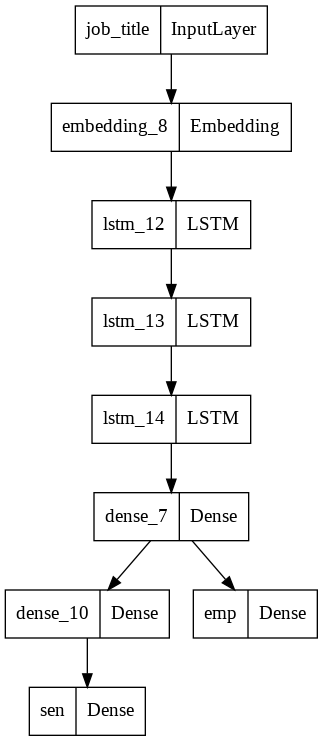

In [62]:
tf.keras.utils.plot_model(model)

In [59]:
model.compile(loss=['categorical_crossentropy','categorical_crossentropy'], optimizer="adam", metrics=['accuracy'])

In [60]:
epochs = 50
batch_size = 1024

history = model.fit(X_train, [Y_emp_train, Y_sen_train], epochs=epochs, batch_size=batch_size,validation_data=(X_val,[Y_emp_val,Y_sen_val]),
                    callbacks=[EarlyStopping(monitor='val_loss', patience=2,restore_best_weights=True),
                               WandbCallback(save_model=False)])

Epoch 1/50
63/63 [==============================] - 8s 45ms/step - loss: 2.3099 - emp_loss: 0.7645 - sen_loss: 1.5454 - emp_accuracy: 0.8544 - sen_accuracy: 0.4410 - val_loss: 2.0043 - val_emp_loss: 0.5721 - val_sen_loss: 1.4322 - val_emp_accuracy: 0.8661 - val_sen_accuracy: 0.4663
Epoch 2/50
63/63 [==============================] - 1s 24ms/step - loss: 1.9910 - emp_loss: 0.5576 - sen_loss: 1.4334 - emp_accuracy: 0.8704 - sen_accuracy: 0.4698 - val_loss: 2.0059 - val_emp_loss: 0.5728 - val_sen_loss: 1.4332 - val_emp_accuracy: 0.8661 - val_sen_accuracy: 0.4663
Epoch 3/50
63/63 [==============================] - 2s 24ms/step - loss: 1.9705 - emp_loss: 0.5559 - sen_loss: 1.4146 - emp_accuracy: 0.8704 - sen_accuracy: 0.4698 - val_loss: 1.8692 - val_emp_loss: 0.5667 - val_sen_loss: 1.3025 - val_emp_accuracy: 0.8661 - val_sen_accuracy: 0.4663
Epoch 4/50
63/63 [==============================] - 2s 24ms/step - loss: 1.7321 - emp_loss: 0.5479 - sen_loss: 1.1842 - emp_accuracy: 0.8705 - sen_accu

In [49]:
accr = model.evaluate(X_test,[Y_emp_test,Y_sen_test])
#print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

625/625 [==============================] - 5s 6ms/step - loss: 1.4026 - emp_loss: 0.4718 - sen_loss: 0.9308 - emp_accuracy: 0.8788 - sen_accuracy: 0.6858


In [48]:
new_title = "Expert Machine Learning Engineer"
new_title = [clean_text(new_title)]
seq = tokenizer.texts_to_sequences(new_title)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
padded

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 349,
         68, 194,   6]], dtype=int32)

In [49]:
model.predict(padded)

array([[0.18349935, 0.0025292 , 0.3245596 , 0.00402707, 0.00080688,
        0.19039497, 0.29418296]], dtype=float32)

In [53]:
pd.get_dummies(train.seniority_level).columns

Index(['Associate', 'Director', 'Entry level', 'Executive', 'Internship',
       'Mid-Senior level', 'Not Applicable'],
      dtype='object')

In [50]:
labels = list(pd.get_dummies(train.seniority_level).columns)

In [58]:
def predict_label(new_title):
  new_title = [clean_text(new_title)]
  seq = tokenizer.texts_to_sequences(new_title)
  padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
  pred = model.predict(padded)
  #labels = ['Credit reporting, credit repair services, or other personal consumer reports', 'Debt collection', 'Mortgage', 'Credit card or prepaid card', 'Student loan', 'Bank account or service', 'Checking or savings account', 'Consumer Loan', 'Payday loan, title loan, or personal loan', 'Vehicle loan or lease', 'Money transfer, virtual currency, or money service', 'Money transfers', 'Prepaid card']
  labels = list(pd.get_dummies(train.seniority_level).columns)
  return labels[np.argmax(pred)]

In [59]:
predict_label("Intern")

'Internship'

In [63]:
#@title Enter new title { run: "auto", vertical-output: true }

new_title = "Junior Research Scientist"  #@param
new_title = [clean_text(new_title)]
seq = tokenizer.texts_to_sequences(new_title)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
#labels = ['Credit reporting, credit repair services, or other personal consumer reports', 'Debt collection', 'Mortgage', 'Credit card or prepaid card', 'Student loan', 'Bank account or service', 'Checking or savings account', 'Consumer Loan', 'Payday loan, title loan, or personal loan', 'Vehicle loan or lease', 'Money transfer, virtual currency, or money service', 'Money transfers', 'Prepaid card']
labels = list(pd.get_dummies(train.seniority_level).columns)
print( labels[np.argmax(pred)])
print((pred))


Associate
[[0.46950844 0.00327721 0.29798684 0.00201656 0.00072411 0.09468381
  0.13180302]]


In [ ]:
list(train.seniority_level.value_counts().index)

['Entry level',
 'Associate',
 'Mid-Senior level',
 'Not Applicable',
 'Director',
 'Internship',
 'Executive']

In [ ]:
pd.get_dummies(train.seniority_level).columns

Index(['Associate', 'Director', 'Entry level', 'Executive', 'Internship',
       'Mid-Senior level', 'Not Applicable'],
      dtype='object')

In [ ]:
print(config)

{'learning_rate': 0.01, 'lower_case': True, 'optimizer': 'adam', 'batch_size': 2048, 'dropout': 0.2, 'r_dropout': 0.2, 'lstm': 128, 'MAX_NB_WORDS': 10000, 'MAX_SEQUENCE_LENGTH': 16, 'EMBEDDING_DIM': 512, 'rnn_dim': 128, 'rnn_type': 'gru'}


## Sweep

In [ ]:
def train():
    config_defaults = {
        'learning_rate': 0.01, 
        'lower_case': True, 
        'optimizer': 'adam', 
        'batch_size': 2048, 
        'dropout': 0.2, 
        'r_dropout': 0.2, 
        'rnn_dim': 128, 
        'rnn_type': "gru",
        'MAX_NB_WORDS': 10000, 
        'MAX_SEQUENCE_LENGTH': 16, 
        'EMBEDDING_DIM': 512
        }


    wandb.init(project='lipik', entity='ivanzidov',config=config_defaults)

    model = Sequential()
    model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
    model.add(SpatialDropout1D(0.2))
    if config.rnn_type=="lstm":
        model.add(LSTM(config.rnn_dim, dropout=config.dropout, recurrent_dropout=config.r_dropout))
    else:
        model.add(GRU(config.rnn_dim, dropout=config.dropout, recurrent_dropout=config.r_dropout))
    model.add(Dense(7, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=config.optimizer, metrics=['accuracy'])

    print(model.summary())

    epochs = 50
    batch_size = config.batch_size

    history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_data=(X_val,Y_val),
                        callbacks=[EarlyStopping(monitor='val_loss', patience=2,restore_best_weights=True),WandbCallback(save_model=False)])


In [ ]:
sweep_config = {
    'method': 'grid', #grid, random
    'metric': {
      'name': 'val_loss',
      'goal': 'minimize'   
    },
    'parameters': {
        'batch_size': {
            'values': [2048, 128]
        },
        'rnn_type':{
            'values':["gru","lstm"]
        },
        'rnn_dim':{
            'values':[64,256]
        },
        'optimizer': {
            'values': ['adam', 'RMSprop']
        },
    }
}

In [ ]:
sweep_id = wandb.sweep(sweep_config, project='lipik', entity='ivanzidov')

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Create sweep with ID: th0hf6xo
Sweep URL: https://wandb.ai/ivanzidov/lipik/sweeps/th0hf6xo


In [ ]:
wandb.agent(sweep_id, train)

wandb: Agent Starting Run: lp56hvem with config:
wandb: 	batch_size: 2048
wandb: 	optimizer: adam
wandb: 	rnn_dim: 64
wandb: 	rnn_type: gru
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 16, 512)           5120000   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 16, 512)           0         
_________________________________________________________________
gru (GRU)                    (None, 128)               246528    
_________________________________________________________________
dense (Dense)                (None, 7)                 903       
Total params: 5,367,431
Trainable params: 5,367,431
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
32/32 [==============================] - 56s 2s/step - loss: 1.6265 - accuracy: 0.4372 - val_loss: 1.1523 - val_accuracy: 0.5863
Epoch 2/50
32/32 [==============================] - 53s 2s/step - loss: 1.0765 - accuracy: 0.6192 -